In [1]:
# Code written by my MXM project teammate Lucas Allen (Github: lallen29). Will be modified by me.
# pytorch mlp for regression
import os
import numpy as np
from numpy import vstack
from numpy import sqrt
import pandas as pd
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import time

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import Sigmoid, ReLU
from torch.nn import Module
from torch.optim import SGD
from torch.nn import MSELoss
from torch.nn.init import xavier_uniform_

import matplotlib.pyplot as plt

In [2]:
def read_train_csv(percent):
    
    data = np.load('random_data_1.npy')

    top_train_index = int(len(data) * percent)
    
    X = data[:top_train_index, 0:257]
    y = data[:top_train_index, 257:]

    '''
    How should we scale the inputs? 
    Scaling so that all inputs are roughly the same order of magnitude can help the model converge faster.
    However, for nn it appears scaling is theoretically not necessary.
    '''
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X = scaler_x.fit_transform(X)
    y = scaler_y.fit_transform(y)
    
    return X, y, scaler_x, scaler_y

def read_test_csv(percent, scaler_x, scaler_y):
    
    data = np.load('random_data_1.npy')

    bottom_test_index = int(len(data) * percent)
    
    X = data[bottom_test_index:, 0:257]
    y = data[bottom_test_index:, 257:]

    X = scaler_x.transform(X)
    y = scaler_y.transform(y)
    
    return X, y

In [3]:
# dataset definition
class prepare_train_Dataset(Dataset):
    # load the dataset
    def __init__(self):
        
        X, y, self.scaler_x, self.scaler_y = read_train_csv(0.8)
        self.X, self.y = torch.from_numpy(X).float().to(device), torch.from_numpy(y).float().to(device)        
        
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
    
    def get_scalers(self):
        return self.scaler_x, self.scaler_y
    
# dataset definition
class prepare_test_Dataset(Dataset):
    # load the dataset
    def __init__(self, scaler_x, scaler_y):
        
        X, y = read_test_csv(0.8, scaler_x, scaler_y)
        self.X, self.y = torch.from_numpy(X).float().to(device), torch.from_numpy(y).float().to(device)
           
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [14]:
# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 256)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = Sigmoid()
        
        # second hidden layer
        self.hidden2 = Linear(256, 256)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = Sigmoid()

        # third hidden layer
        self.hidden3 = Linear(256, 256)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid()
        
        # output
        self.out = Linear(256, 256)
        xavier_uniform_(self.out.weight)
 
    # forward propagate input
    # THERE HAS GOT TO BE A BETTER WAY TO WRITE THIS!!!!!
    def forward(self, X):
        
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)

        # third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        
        # output
        X = self.out(X)
        
        return X

In [15]:
# train the model
def train_model(train_dl, model, l_rate, l_momentum):
    size = len(train_dl.dataset)
    # define the optimization
    criterion = MSELoss()
    optimizer = SGD(model.parameters(), lr=l_rate, momentum = l_momentum)

    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_dl):
    
        # clear the gradients
        optimizer.zero_grad(set_to_none=True)
        # compute the model output
        yhat = model(inputs.to(device, non_blocking=True))
        # calculate loss
        loss = criterion(yhat, targets.to(device, non_blocking=True))
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()

        # if i % 1024 == 0:
        #     loss, current = loss.item(), (i + 1) * len(inputs)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs.to(device))
        # retrieve numpy array
        yhat = yhat.cpu().detach().numpy()
        actual = targets.cpu().numpy()
        
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    return mse, predictions

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# hyperparameters
l_rate = 0.04
l_momentum = 0.5
minibatch_size = 64

# load the dataset
#train_indexes, test_indexes = indexes[:int(len(indexes)*0.8)], indexes[int(len(indexes)*0.8):]

train_dataset = prepare_train_Dataset()
scaler_x, scaler_y = train_dataset.get_scalers()
test_dataset = prepare_test_Dataset(scaler_x, scaler_y)

# prepare data loader
test_dl = DataLoader(test_dataset, batch_size = minibatch_size, shuffle=False)


In [48]:
'''
# reset and initialize the network

model = MLP(257).to(device)

test_rmse_arr = []
train_rmse_arr = []

'''

# load our model
model = torch.load('FFNN_1_.pth')



pass

Epoch 9    test RMSE: 0.008846384      train RMSE: 0.0141594075
Epoch 19    test RMSE: 0.00884908      train RMSE: 0.014158881
Epoch 29    test RMSE: 0.008846657      train RMSE: 0.01415842
Epoch 39    test RMSE: 0.008847366      train RMSE: 0.014158282
Epoch 49    test RMSE: 0.00884599      train RMSE: 0.014158352
Epoch 59    test RMSE: 0.008847221      train RMSE: 0.014158088
Epoch 69    test RMSE: 0.008847332      train RMSE: 0.01415751
Epoch 79    test RMSE: 0.008847779      train RMSE: 0.014157236
Epoch 89    test RMSE: 0.008846627      train RMSE: 0.014156919
Epoch 99    test RMSE: 0.008844438      train RMSE: 0.014156793


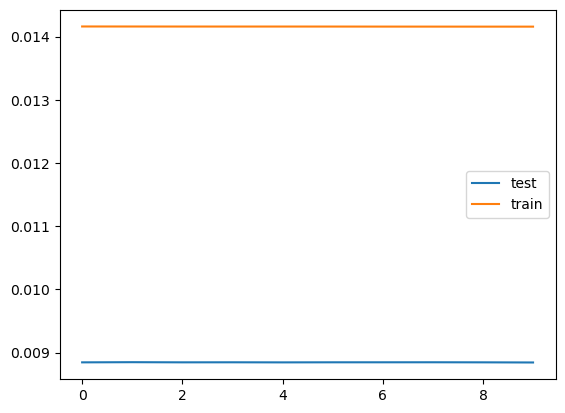

In [49]:

epochs = 100

train_dl = DataLoader(train_dataset, batch_size = minibatch_size, shuffle=True)

test_rmse_arr = []
train_rmse_arr = []


for t in range(epochs):
    #print('Epoch ' + str(t))
    
    # train the model
    train_model(train_dl, model, l_rate, l_momentum)
    
    if t % 10 == 9:
        print('Epoch ' + str(t), end = '    ')
        
        # evaluate the model against testing data
        test_mse, y_pred = evaluate_model(test_dl, model)
        test_rmse = sqrt(test_mse)
        test_rmse_arr.append(test_rmse)
        
        # evaluate the model against training data
        train_mse, y_pred = evaluate_model(train_dl, model)
        train_rmse = sqrt(train_mse)
        train_rmse_arr.append(train_rmse)

        print('test RMSE:', test_rmse, '     train RMSE:', train_rmse)

# save our model
torch.save(model, 'FFNN_1_.pth')

plt.plot(test_rmse_arr, label = 'test')
plt.plot(train_rmse_arr, label = 'train')
plt.legend()
plt.show()

Prediction Time: 0.15920710563659668


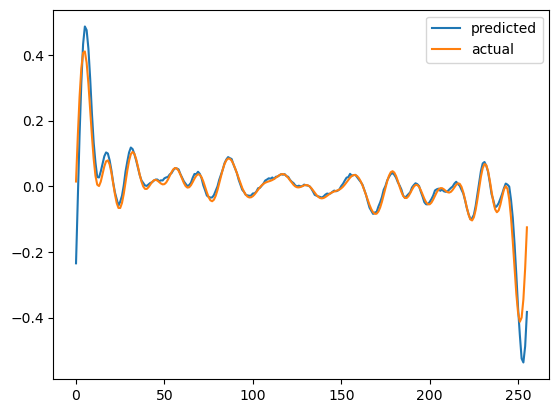

In [63]:
# Predict and validate model
pred_dataset = prepare_test_Dataset(scaler_x, scaler_y)
pred_dl = DataLoader(pred_dataset, batch_size=100, shuffle=False)

start_time = time.time()
mse, y_pred = evaluate_model(pred_dl, model)
y_pred = scaler_y.inverse_transform(y_pred)
print("Prediction Time: " + str(time.time()-start_time))

y_test = scaler_y.inverse_transform(pred_dl.dataset.y.cpu().numpy())

n = 110

xs = np.linspace(0, 256, 256, endpoint = False)
plt.plot(xs, y_pred[n], label = 'predicted')
plt.plot(xs, y_test[n], label = 'actual')
plt.legend()
plt.show()

MLP(
  (hidden1): Linear(in_features=257, out_features=256, bias=True)
  (act1): Sigmoid()
  (hidden2): Linear(in_features=256, out_features=256, bias=True)
  (act2): Sigmoid()
  (hidden3): Linear(in_features=256, out_features=256, bias=True)
  (act3): Sigmoid()
  (out): Linear(in_features=256, out_features=256, bias=True)
)